In [ ]:
#Install dependencies
!pip install pymc
!pip install numpy
!pip install arviz
!pip install erroranalysis
!pip install plotly
!pip install kaleido
!pip install forestplot

In [ ]:
#Import dependencies
import pymc as pm
import numpy as np
import arviz as az
import random as rm
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import gc
import math
import plotly
import plotly.graph_objects as grobj
import plotly.express as ex
from google.colab import files
from google.colab import data_table
from vega_datasets import data
import seaborn as sns

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.1.4


In [ ]:
######### Generate simulated data if needed or read in file #########
agentCols=[]

# Reading the dataset from the file. ****NEED TO UPLOAD THE DATA INTO COLAB EACH TIME. IT WILL GET DELETED AFTER EACH SESSION IS TERMINATED****
df = pd.read_csv ('AgentsWithMetaData.csv')#pd.read_csv ('AgentsWithMetaData.csv')

#Create list of agents included in the data. Assumes naming convention Agent1, Agent2, etc.
agentCols = df.columns[df.columns.str.contains('Agent')]
print(agentCols)


In [ ]:
####Clean up feature data columns#######

df['OccluderPresence']= (df['TimeUnderOcclusion'] != 0) * 1.0   # Creating new variable for OccluderPresence
df['NumOtherPositionsAvailable'] = df['NumOtherPositionsAvailable'].fillna(0)  # Replace nans by 0s
df['GoalSize']=df['GoalSize'].astype(np.double)
df["OccluderRedness"]=df["OccluderRedness"].fillna(0)
df["OccluderGreenness"]=df["OccluderGreenness"].fillna(0)
df["OccluderBlueness"]=df["OccluderBlueness"].fillna(0)

#Print unique values for key features
print('TimeUnderOcclusion: ',df['TimeUnderOcclusion'].unique())
print('RightLeftPosition: ',df['RightLeftPosition'].unique())
print('NumOtherPositionsAvailable: ',df['NumOtherPositionsAvailable'].unique())
print('Goal sizes: ',df['GoalSize'].unique())   
print('Occluder Colours: ',df['OccluderColour'].unique())  # Still need to have an extra arrow to occluder for nans

#Print head of dataframe
print(df.head())


In [ ]:
######Define values & functions that will be used to define the model later########
uniformAbilitySlack = 1.0 # Constant to multiply the maximum of abilities that are uniform to allow for the value to be above the maximum observable value for the corresponding feature

#Decide "maximum capabilities" based on the hardest values in the dataset
maxTime = max(df["TimeUnderOcclusion"])
maxPositions = max(df["NumOtherPositionsAvailable"])
maxGoalSize= max(df["GoalSize"])
maxDistanceToGoal= max(df["DistanceToGoalManhattan"])
maxPermAbility = 1  
maxMemoryAbility = maxTime * uniformAbilitySlack     
maxSpatialAbility = maxPositions * uniformAbilitySlack  
maxVisualAcuityAbility = maxGoalSize* uniformAbilitySlack   
maxFlatNavAbility = maxDistanceToGoal * uniformAbilitySlack

#Define useful functions for use within the model
def scaledBeta(name, a, b, min, max):
  beta = pm.Beta(f"{name}_raw", a, b)
  return pm.Deterministic(name, beta * (max - min) + min)

def logistic(x):
  return 1 / (1 + np.exp(-x))

def SimplePrMargin(ability, binaryFeature): # must return a value between 0 and 1
  return 1-((1-ability)*binaryFeature)  # If binaryFeature is 0 then the margin represents p(success)=1. If binaryFeature = 1 then p(success)=ability

def objPermanenceLOMargin(objPermAbility, occluderPresence, memoryP, spatialP): #,  visualAcuityP): # must return a value between -inf and inf (more precisely between -maxPermAbility and maxPermAbility)
  margin = 1 - ((1-objPermAbility * memoryP * spatialP)*occluderPresence) #if occluderPresence == 0, return 1. If obj perm == 0, returns 0. Else, return memoryP * spatialP
  return margin
def visualAcuityLOMargin(ability, goalSmallness): # must return a value between -inf and inf  (more precisely between -maxVisualAcuityAbility and maxVisualAcuityAbility)
  return ability - goalSmallness   # Goes between -inf to inf, with logodds=0 meaning this would lead to 0.5 chance of success

def memoryLOMargin(ability, timeUnderOcc): # must return a value between -inf and inf  (more precisely between -maxMemoryAbility and maxMemoryAbility)
  return ability - timeUnderOcc   # Goes between -inf to inf, with logodds=0 meaning this would lead to 0.5 chance of success

def spatialLOMargin(ability, numPositions): # must return a value between -inf and inf  (more precisely between -maxSpatialAbility and maxSpatialAbility)
  return ability - numPositions   # Goes between -inf to inf, with logodds=0 meaning this would lead to 0.5 chance of success

def flatNavMargin(ability, distanceToGoal): # must return a value between -inf and inf  (more precisely between -maxSpatialAbility and maxSpatialAbility)
  return ability - distanceToGoal   # Goes between -inf to inf, with logodds=0 meaning this would lead to 0.5 chance of success

def navigationPrMargin(simpleNavigationP, lavaP, rampP, platP) :  # , visualAcuityP): # must return a value between 0 and 1
  return simpleNavigationP * lavaP * rampP * platP # * visualAcuityP  # I think a product makes more sense, since if lavaPerf is zero, this means there's lava and the ability of handling lava is zero, with a high probability of failure.
  # It's probably better to use some weighted generalised mean, but for the moment the product makes more sense

def finalTaskPrMargin(objPermanenceP, navigationP, visualAcuityP, randomFailParameter = 0, randomSuccessParameter = 0): # must return a value between 0 and 1
  margin = objPermanenceP * navigationP * visualAcuityP #Calculate raw margin
  randomFailAdjustedMargin = margin * (1-randomFailParameter) #if randomFailPar == 1 then set performance to zero regardless of margin
  randomSuccessAdjustedMargin = 1 - ((1-randomFailAdjustedMargin)*(1-randomSuccessParameter)) #if randomSuccessPar == 1 then pass regardless of margin
  return randomSuccessAdjustedMargin
  
abilityMin = {} #Initialize ability Min and max dataframes for plotting ranges
abilityMax = {}

In [ ]:
###### Define function that generates a PyMC model following our theorised structure. This will be called once for each agent.
#Boolean checks to enable or disable certain features of the model
includeIrrelevantFeatures = False #whether to include features that are irrelevant to performance (e.g. colour)
includeStochasticity = True

#Set up the inference model, passing in the task results
def SetupModel(taskResults):
  m = pm.Model()
  with m:
    #Memory longevity
    memoryAbility = scaledBeta("memoryAbility", 1,1, 0, maxMemoryAbility)  # [0,maxMemoryAbility] This is the same as above, but we have the ability in the right magnitude
    abilityMin["memoryAbility"] = 0
    abilityMax["memoryAbility"] = maxMemoryAbility
    
    #Object permanence
    objPermAbility = pm.Beta("objPermAbility",1,1)
    abilityMin["objPermAbility"] = 0
    abilityMax["objPermAbility"] = 1

    #Spatial memory ability
    spatialAbility = scaledBeta("spatialAbility", 1,1, 0, maxSpatialAbility)
    abilityMin["spatialAbility"] = 0
    abilityMax["spatialAbility"] = maxSpatialAbility                         

    #Visual acuity                     # The 1.1 is to have some margin to see also if it overestimates in those cases where this ability is maximal
    visualAcuityAbility = scaledBeta("visualAcuityAbility", 1,1,0, maxVisualAcuityAbility)
    abilityMin["visualAcuityAbility"] = 0
    abilityMax["visualAcuityAbility"] = maxVisualAcuityAbility
    
    #Ability to navigate across distances to a reward
    flatNavAbility = scaledBeta("flatNavAbility", 1,1,0, maxDistanceToGoal)                # [-inf,inf] This is an ability centered on 0, as it is used directly as a logit joinlty with the Left/Right influence
    abilityMin["flatNavAbility"] = 0
    abilityMax["flatNavAbility"] = maxFlatNavAbility

    #Ability to deal with lava
    lavaAbility = pm.Beta("lavaAbility", 1,1)                        # [0,1] Specific ability with lava
    abilityMin["lavaAbility"] = 0
    abilityMax["lavaAbility"] = 1

    #Ability to deal with platforms
    platformAbility = pm.Beta("platformAbility",1,1)                  # [0,1] Specific ability with platforms
    abilityMin["platformAbility"] = 0
    abilityMax["platformAbility"] = 1
    
    #Ability to deal with ramps
    rampAbility = pm.Beta("rampAbility",1,1)                          # [0,1] Specific ability with ramps
    abilityMin["rampAbility"] = 0
    abilityMax["rampAbility"] = 1
    
    # Other properties of the agent that we wouldn't call abilities, we can call them "bias"
    if (includeIrrelevantFeatures) :
      rightLeftBias = pm.Normal("rightLeftBias", 0,1)                  # [-inf,inf] A parameter to determine whether left or right have an influence. It's expected to be zero, but negative would be left influence and positive a right influence (or vice versa :-) 
      abilityMin["rightLeftBias"] = -np.inf
      abilityMax["rightLeftBias"] = np.inf
      rednessBias = pm.Normal("rednessBias", 0,1)                      # [-inf,inf] A parameter to determine whether redness has an influence
      abilityMin["rednessBias"] = -np.inf
      abilityMax["rednessBias"] = np.inf
      greennessBias = pm.Normal("greennessBias", 0,1)                  # [-inf,inf] A parameter to determine whether greenness has an influence
      abilityMin["greennessBias"] = -np.inf
      abilityMax["greennessBias"] = np.inf
      bluenessBias = pm.Normal("bluenessBias", 0,1)                    # [-inf,inf] A parameter to determine whether blueness has an influence  
      abilityMin["bluenessBias"] = -np.inf
      abilityMax["bluenessBias"] = np.inf

    ## Environment variables as Deterministic (about the instance)
    ## RELEVANT
    lavaPresence = pm.Deterministic("lavaPresence", pm.math.constant(df["LavaPresence"].values))
    rampPresence = pm.Deterministic("rampPresence", pm.math.constant(df["RampPresence"].values))
    platformPresence = pm.Deterministic("platformPresence", pm.math.constant(df["PlatformPresence"].values))
    timeUnderOcc = pm.Deterministic("timeUnderOcc", pm.math.constant(df["TimeUnderOcclusion"].values))
    distanceToGoalManhattan = pm.Deterministic("distanceToGoalManhattan", pm.math.constant(df["DistanceToGoalManhattan"].values))
    numPositions = pm.Deterministic("numPositions", pm.math.constant(df["NumOtherPositionsAvailable"].values))
    occluderPresence = pm.Deterministic("occluderPresence", pm.math.constant(df["OccluderPresence"].values))
    goalSize = pm.Deterministic("goalSize", pm.math.constant(df["GoalSize"].values))

    ## SUPPOSEDLY IRRELEVANT
    if (includeIrrelevantFeatures) :
      rightLeftPosition = pm.Deterministic("rightLeftPosition", pm.math.constant(df["RightLeftPosition"].values))
      occluderRedness = pm.Deterministic("occluderRedness", pm.math.constant(df["OccluderRedness"].values))
      occluderGreenness = pm.Deterministic("occluderGreenness", pm.math.constant(df["OccluderGreenness"].values))
      occluderBlueness = pm.Deterministic("occluderBlueness", pm.math.constant(df["OccluderBlueness"].values))

    #goal size relative to the max
    goalSmallness = maxGoalSize - goalSize
    visualAcuityP = pm.Deterministic("visualAcuityP", logistic(visualAcuityLOMargin(visualAcuityAbility, goalSmallness)))

    if (includeIrrelevantFeatures) :
      rightLeftEffect = pm.Deterministic("rightLeftEffect", rightLeftBias * rightLeftPosition) 
    else :
      rightLeftEffect = 0
      
    ## Performance metrics based on Navigation and hazards
    # Simple navigation including one supposed irrelevant feature
    flatNavM = flatNavMargin(flatNavAbility, distanceToGoalManhattan)
    
    if (includeIrrelevantFeatures) :
      flatNavP = pm.Deterministic("flatNavP", logistic(flatNavM + rightLeftEffect))
    else :
      flatNavP = pm.Deterministic("flatNavP", logistic(flatNavM))
    

    # Other relevant features for non-flat navigation (climbing and jumping)
    lavaP = pm.Deterministic("lavaP", SimplePrMargin(lavaAbility, lavaPresence))
    rampP = pm.Deterministic("rampP", SimplePrMargin(rampAbility, rampPresence))
    platformP = pm.Deterministic("platformP", SimplePrMargin(platformAbility, platformPresence))
    navP = pm.Deterministic("navP", navigationPrMargin(flatNavP, lavaP, rampP, platformP)) #, visualAcuityP)) 
    
    # Occluder Colour Bias
    if (includeIrrelevantFeatures) :
      occluderRednessSign = occluderRedness / 255.0 * 2.0 - 2.0  
      occluderGreennessSign = occluderGreenness / 255.0 * 2.0 - 2.0  
      occluderBluenessSign = occluderBlueness / 255.0 * 2.0 - 2.0  
      occluderColourEffect = pm.Deterministic("occluderColourBias", (rednessBias * occluderRednessSign + greennessBias * occluderGreennessSign + bluenessBias * occluderBluenessSign) * occluderPresence)  # If occluder is not present there should not be any effect  
    else :
      occluderColourEffect = 0  # To ignore the effect of colour in the model

    #Memory performance
    MEMM = memoryLOMargin(memoryAbility, timeUnderOcc)
    memoryP = pm.Deterministic("memoryP", logistic(MEMM))  

    #Spatial ability performance
    SPAM = spatialLOMargin(spatialAbility, numPositions)
    spatialP = pm.Deterministic("spatialP", logistic(SPAM))

    #OP performance determined by memory ability, max time and number of positions - but if no occluder, OP performance should be at maximum. Memory considered to feed into OP and OP performance
    OPLOM = objPermanenceLOMargin(objPermAbility, occluderPresence, memoryP, spatialP) # , visualAcuityP)  # We set timeUnderOcc=maxTime because this has been considered already by memoryP, which will be used later on
    objPermP = pm.Deterministic("objPermP", OPLOM)
    
    #If the model should allow for stochasticity in the agent
    if includeStochasticity : 
      #estimate likelihood of a stochastic failure
      randomFailPar = pm.Bernoulli("randomFailPar", p = 0)
      abilityMin["randomFailPar"] = 0
      abilityMax["randomFailPar"] = 1

      #Assumed random success rate
      randomSuccessRate = pm.Deterministic("randomSuccessRate",pm.math.constant(0.1)) # constant for random success rate
      randomSuccessPar = pm.Bernoulli("randomSuccessPar", randomSuccessRate) #Bernoulli with fixed p based on rSR

      #Now calculate final task performance by combining the various aspects of performance with the stochasticity
      taskPerformance = pm.Bernoulli("taskPerformance", finalTaskPrMargin(objPermP, navP, visualAcuityP, randomFailPar, randomSuccessPar), observed=taskResults)  
    else :  
      taskPerformance = pm.Bernoulli("taskPerformance", finalTaskPrMargin(objPermP, navP, visualAcuityP), observed=taskResults)  
    
  pm.model_graph.model_to_graphviz(m)

  return m

In [ ]:
#Visualize the model structure
from IPython.display import Image
import graphviz  
taskResults = df["Agent1"] #set task results with first agent just to generate the model diagram
m = SetupModel(taskResults)
gv = pm.model_graph.model_to_graphviz(m)
gv.format="png"
gv.render
gv.render(directory='viz')
Image("viz/Digraph.gv.png")
gv

In [ ]:
#Function to analyse the results across several agents
def analyzeAgentResults(agentName, agentData, displayFigs=False):
  data_table.enable_dataframe_formatter()
  abilityMeans = [] # empty list to add in ability means to
  abilitySDs = [] # empty list to add ability SDs to
  for a in abilitiesToShow: #iterate through each ability, add posterior mean to dataframe, and plot posterior
    posteriorMean = float(np.mean(agentData['posterior'][a])) # calculate posterior mean
    posteriorSD = float(np.std(agentData['posterior'][a])) #calculate posterior sd
    abilityMeans.append(posteriorMean)
    abilitySDs.append(posteriorSD)
  return abilityMeans, abilitySDs

In [ ]:
#USE IF YOU WANT TO READ IN RESULTS INSTEAD OF RE-RUNNING THE MODEL, THEN SKIP NEXT BLOCK
#abilityDF = pd.read_csv('modelResults.csv')
#abilityMeanDF = pd.read_csv('abilityMeans.csv')
#abilitySdDF = pd.read_csv('abilitySds.csv')

In [ ]:
##### Sample results for each agent using the model defined earlier.
allAgentData = [] #blank list for entering the outputs of the pm sampling for each agent
agentNames = [] #blank list for the agent names
agentColList = agentCols.tolist()
print(agentColList)
numAgents = len(agentColList) #Number of agents, replace with a small number for testing to save time
numAgents = 4 #!!!DEBUG CODE to run subset of agents, comment out for full agent run!!!

print(numAgents)
abilitiesToShow = ["objPermAbility", "memoryAbility","spatialAbility", "flatNavAbility", "visualAcuityAbility","lavaAbility", "platformAbility", "rampAbility"]
if (includeIrrelevantFeatures) :
  abilitiesToShow = abilitiesToShow + ["rightLeftBias", "rednessBias", "greennessBias", "bluenessBias"]
if (includeStochasticity) :
  abilitiesToShow = abilitiesToShow + ["randomFailPar"] # ["noise", "noisePar"]

includePerformance = True


abilityDF = pd.DataFrame( {'Ability': abilitiesToShow})#Set up dataframe for printing with abilities as rows, to which agent means and sds will be added as cols
abilityMeanDF = pd.DataFrame( {'Ability': abilitiesToShow})#Set up df for analysis and saving
abilitySdDF = pd.DataFrame( {'Ability': abilitiesToShow})#Set up df for analysis and saving

#tempDistDF = 
if (includePerformance):
  abilitiesToShow2 = abilitiesToShow + ["Success"]
  abilityDF2 = pd.DataFrame( {'Ability': abilitiesToShow2})

for i in range(numAgents): #numAgents Iterate through each agent. 
  agent = agentCols[i] #Get the agent name
  taskResults = df[agent] #Grab the column of results for that agent
  print(agent) 
  print(np.mean(taskResults)) #print mean performance for the agent across all tasks
  m = SetupModel(taskResults) #Define the model using the setupModel function. Needs to be redefined each run after taskResults are updated or PyMC won't use the latest taskResults
  
  #Now sample based on this agent's performance
  with m: 
    agentData = pm.sample(1000) #Might need more samples to converge
 
  mu, sd  = analyzeAgentResults(agent, agentData) #extract mean and sd estimates for the agent

  abilityMeanDF[agent] = mu
  abilitySdDF[agent] = sd

  abilityMeans= [str(round(mu_i, 2))+" " for mu_i in mu]  # round and turn to string for combining and printing
  abilitySDs = ["     "+str(round(sd_i,2)) for sd_i in sd ]  # round and turn to string for combining and printing

 
  abilityDF[agent] = list(zip(abilityMeans, abilitySDs)) # combine strings together for printing as a table
  abilityDFRaw = list(zip(mu, sd)) #Combine means and sds and add to raw dataframe for analysis and saving

  if (includePerformance): #If we're also adding overall task performance for each agent
    abilityMeans = abilityMeans + [str(round(np.mean(taskResults),2))+" "] #add overall mean to list
    abilitySDs = abilitySDs + [str(round(np.std(taskResults), 2))] #add overall sd to list
    abilityDF2[agent] = list(zip(abilityMeans, abilitySDs)) 

if (includePerformance):
  abilityDF = abilityDF2



In [ ]:
#Download the results into csv files
abilityDF.to_csv('modelResults.csv', index = False) 
abilityMeanDF.to_csv('abilityMeans.csv', index = False)
abilitySdDF.to_csv('abilitySds.csv', index = False)

files.download('modelResults.csv')
files.download('abilityMeans.csv')
files.download('abilitySds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Print ability DF with means and Sds
abilityDF

,Ability,Agent1,Agent2,Agent3,Agent4
0,objPermAbility,"(0.5 , 0.29)","(0.99 , 0.01)","(0.96 , 0.04)","(0.88 , 0.09)"
1,memoryAbility,"(2.0 , 1.13)","(3.97 , 0.03)","(3.85 , 0.13)","(3.44 , 0.42)"
2,spatialAbility,"(5.55 , 3.2)","(10.9 , 0.1)","(10.37 , 0.52)","(10.36 , 0.57)"
3,flatNavAbility,"(27.81 , 16.52)","(55.94 , 0.06)","(55.8 , 0.18)","(51.27 , 2.46)"
4,visualAcuityAbility,"(2.55 , 1.46)","(4.01 , 0.08)","(0.78 , 0.12)","(0.14 , 0.1)"
5,lavaAbility,"(0.49 , 0.29)","(0.76 , 0.03)","(0.89 , 0.07)","(0.44 , 0.11)"
6,platformAbility,"(0.5 , 0.29)","(0.88 , 0.04)","(0.91 , 0.06)","(0.45 , 0.14)"
7,rampAbility,"(0.5 , 0.28)","(0.86 , 0.03)","(0.81 , 0.09)","(0.66 , 0.15)"
8,stochasticityPar,"(0.0 , 0.0)","(0.0 , 0.0)","(0.0 , 0.0)","(0.0 , 0.0)"
9,Success,"(1.0 , 0.0)","(0.5 , 0.5)","(0.1 , 0.3)","(0.03 , 0.18)"


In [ ]:
##### Helper function to max-min normalize the variables
def scaleVector(vect, min, max):
  scaledVect = (vect - min)/(max-min)
  return scaledVect

In [ ]:
###Normalise values for plotting
#Transpose DFs so that abilities are columns and agents are rows
abilityMeanDFScaled = abilityMeanDF.set_index('Ability').T
abilitySdDFScaled = abilitySdDF.set_index('Ability').T

#Now scale the variables to between 0 and 1 for plotting and ease of interpretation
#print(abilityMeanDFScaled["objPermAbility"])
abilityMeanDFScaled["objPermAbility"] = scaleVector(abilityMeanDFScaled["objPermAbility"], abilityMin["objPermAbility"], abilityMax["objPermAbility"]) #Scale based on max theoretical OP
abilityMeanDFScaled["flatNavAbility"] = scaleVector(abilityMeanDFScaled["flatNavAbility"], np.min(abilityMeanDFScaled["flatNavAbility"]), np.max(abilityMeanDFScaled["flatNavAbility"])) #scale based on max Nav ability in database
abilityMeanDFScaled["visualAcuityAbility"] = scaleVector(abilityMeanDFScaled["visualAcuityAbility"], abilityMin["visualAcuityAbility"], abilityMax["visualAcuityAbility"]) #Scale based on max theoretical visual ability
abilityMeanDFScaled["memoryAbility"] = scaleVector(abilityMeanDFScaled["memoryAbility"], abilityMin["memoryAbility"], abilityMax["memoryAbility"]) #Scale based on max theoretical visual ability
#abilityMeanDFScaled["rightLeftBias"] = scaleVector(abilityMeanDFScaled["rightLeftBias"], np.max(abilityMeanDFScaled["rightLeftBias"]), np.min(abilityMeanDFScaled["rightLeftBias"])) #Scale based on min/max biases
#abilityMeanDFScaled["rednessBias"] = scaleVector(abilityMeanDFScaled["rednessBias"], np.max(abilityMeanDFScaled["rednessBias"]), np.min(abilityMeanDFScaled["rednessBias"])) #Scale based on min/max biases
#abilityMeanDFScaled["bluenessBias"] = scaleVector(abilityMeanDFScaled["bluenessBias"], np.max(abilityMeanDFScaled["bluenessBias"]), np.min(abilityMeanDFScaled["bluenessBias"])) #Scale based on min/max biases
#abilityMeanDFScaled["greennessBias"] = scaleVector(abilityMeanDFScaled["greennessBias"], np.max(abilityMeanDFScaled["greennessBias"]), np.min(abilityMeanDFScaled["greennessBias"])) #Scale based min/max biases

#Now scale SDs
abilitySdDFScaled["objPermAbility"] = scaleVector(abilitySdDFScaled["objPermAbility"], abilityMin["objPermAbility"], abilityMax["objPermAbility"]) #Scale based on max theoretical OP
abilitySdDFScaled["flatNavAbility"] = scaleVector(abilitySdDFScaled["flatNavAbility"], np.min(abilityMeanDFScaled["flatNavAbility"]), np.max(abilityMeanDFScaled["flatNavAbility"])) #scale based on max Nav ability in database
abilitySdDFScaled["visualAcuityAbility"] = scaleVector(abilitySdDFScaled["visualAcuityAbility"], abilityMin["visualAcuityAbility"], abilityMax["visualAcuityAbility"]) #Scale based on max theoretical visual ability
abilitySdDFScaled["memoryAbility"] = scaleVector(abilitySdDFScaled["memoryAbility"], abilityMin["memoryAbility"], abilityMax["memoryAbility"]) #Scale based on max theoretical visual ability
#abilitySdDFScaled["rightLeftBias"] = scaleVector(abilitySdDFScaled["rightLeftBias"], np.max(abilityMeanDFScaled["rightLeftBias"]), np.min(abilityMeanDFScaled["rightLeftBias"])) #Scale based on min/max biases
#abilitySdDFScaled["rednessBias"] = scaleVector(abilitySdDFScaled["rednessBias"], np.max(abilityMeanDFScaled["rednessBias"]), np.min(abilityMeanDFScaled["rednessBias"])) #Scale based on min/max biases
#abilitySdDFScaled["bluenessBias"] = scaleVector(abilitySdDFScaled["bluenessBias"], np.max(abilityMeanDFScaled["bluenessBias"]), np.min(abilityMeanDFScaled["bluenessBias"])) #Scale based on min/max biases
#abilitySdDFScaled["greennessBias"] = scaleVector(abilitySdDFScaled["greennessBias"], np.max(abilityMeanDFScaled["greennessBias"]), np.min(abilityMeanDFScaled["greennessBias"])) #Scale based on min/max biases


In [ ]:
#Download scaled data
#abilityDF.to_csv(index=False) # write outputs to file to save compute later 
abilityMeanDFScaled.to_csv('scaledAbilityMeans.csv', index = False)
abilitySdDFScaled.to_csv('scaledAbilitySds.csv', index = False)


files.download('modelResults.csv')
files.download('scaledAbilityMeans.csv')
files.download('scaledAbilitySds.csv')

In [ ]:
#Radar charts for agents
#Set up abilities to be included in the charts
abilitiesToPlot = ['objPermAbility', 'flatNavAbility', 'visualAcuityAbility', 'lavaAbility', 'platformAbility', 'rampAbility', 'memoryAbility']
#Iterate through the agents (each is one row) and plot
for index, row in abilityMeanDFScaled.iterrows():
  
  plotData = row.loc[abilitiesToPlot] #extract data for only the abilities to be plotted
  figData = pd.DataFrame(dict(r= plotData, theta=abilitiesToPlot)) #create plot dataframe, r = results, theta = spoke names
  fig = ex.line_polar(figData, r='r', theta='theta', line_close=True, range_r = [0,1], title = ("Abilities of " + index)) #make plot
  fig.show() #Print plot
  fig.write_image("viz/" + index + "Radar.png") #Write to file in viz folder with agent name (index)

In [ ]:
#Set up data for forest plots
fpData = pd.DataFrame({'Ability': abilitiesToPlot})
fpData.index = fpData['Ability']
fpData['M'] = abilityMeanDFScaled.loc['Agent1',abilitiesToPlot]# abilityMeanDFScaled.loc[1,abilitiesToPlot]#abilitiesToPlot].loc[abilitiesToPlot]
fpData['Sd'] = abilitySdDFScaled.loc['Agent1',abilitiesToPlot]# abilityMeanDFScaled.loc[1,abilitiesToPlot]#abilitiesToPlot].loc[abilitiesToPlot]


In [ ]:
#Forest plot helper function
def forestPlot(df, agentName):
  fig, ax = plt.subplots(figsize=(15, 10))
  df.plot(x='Ability', y='M', kind='barh',
              ax=ax, color='none', fontsize=22, 
              ecolor='steelblue',capsize=0,
              xerr='Sd', legend=False)
    
  # Set title & labels
  plt.title('Ability estimates for ' + agentName,fontsize=30)
  ax.set_ylabel('Coefficients',fontsize=22)
  ax.set_xlabel('',fontsize=22)
  
  #Coefficients
  ax.scatter(y=pd.np.arange(df.shape[0]), 
              marker='o', s=80, 
              x=df['M'], color='steelblue')
  
  # Line to define zero on the y-axis
  #ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
  plt.xlim([0, 1.1])
  plt.savefig("viz/"+agentName + "Forest.png")
  return plt.show()

In [ ]:
#Create forest plots for each agent

for i in range(len(abilityMeanDFScaled)):
  print(i)
  agentName = abilityMeanDFScaled.index[i]
  fpData = pd.DataFrame({'Ability': abilitiesToPlot}) #create temp dataset for combining means and sds for the agent
  fpData.index = fpData['Ability'] #set index as ability
  fpData['M'] = abilityMeanDFScaled.iloc[i,:].loc[abilitiesToPlot]# add means for the agent
  fpData['Sd'] = abilitySdDFScaled.iloc[i,:].loc[abilitiesToPlot]# add sds for the agent

  forestPlot(fpData, agentName)


In [ ]:
#Download all the plots in the viz folder
!zip -r /content/file.zip /content/viz #Zip folder
files.download("/content/file.zip") #download

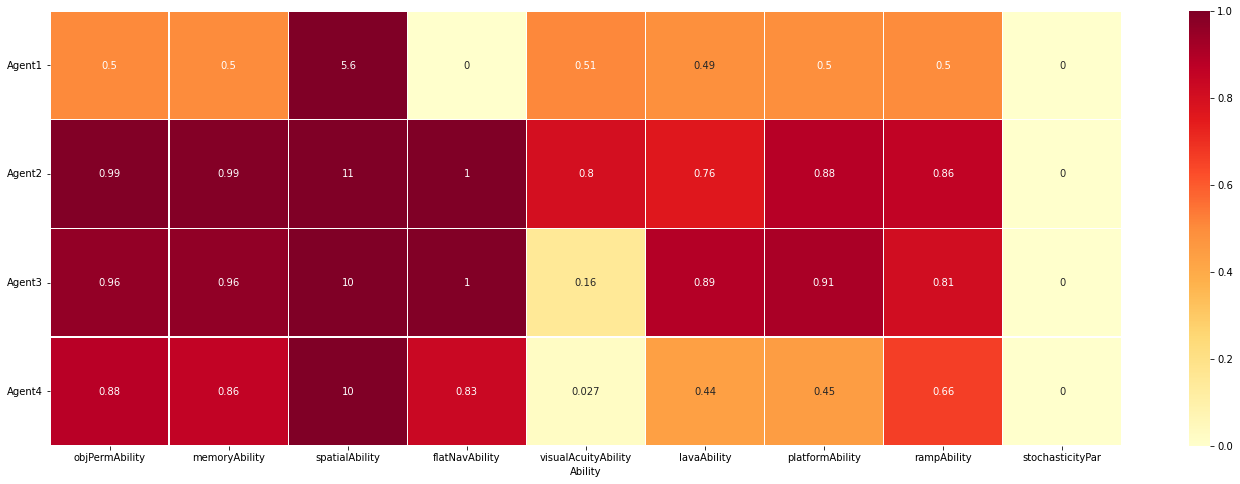

In [ ]:
#Print performance grid

#Set up data
agentPerformancesDataframe = abilityMeanDFScaled

# change fig dimensions
f = plt.figure()
f.set_figwidth(24)
f.set_figheight(8)

# plot heatmap with some parameters

sns.heatmap(agentPerformancesDataframe, linewidths = .5, annot = True, cmap = 'YlOrRd', vmin = 0, vmax = 1) # heat map with separators between boxes, annotations of ability numbers, and colour palette

# change rotation of y axis tick labels for readability
plt.yticks(rotation=0) 

plt.show()